## 1. Task 1: Expectation before beginning
A. **[Each, TURN THIS IN]** Before beginning this assignment, briefly characterize in writing your expectation of what you will find to be predictive of an individual having high medical expenses. We learned about this in the last labs, but this one will use a different model and a different explainer. So how do you think this one might be different?

B. Run the following cells in Pre-task to set up packages and prepare the data

Note that the data retrieval and wrangling are the same as in the previous lab



### Predicting Medical Expenditures - Use Case Information

The Medical Expenditure Panel Survey (MEPS) is a set of large-scale surveys of families and individuals, their medical providers, and employers across the United States. MEPS is the most complete source of data on the cost and use of health care and health insurance coverage. For more information on MEPS, consult the following link (you may be particularly interested to search up column names in the codebook to understand their meaning and the values each can take):

https://meps.ahrq.gov/mepsweb/

We will work on the 2015 Full Year Consolidated Data file (HC-181), downloaded from:

https://www.nber.org/research/data/ahrq-medical-expenditure-panel-survey-data-meps

The contents of this notebook pull from the resources located here:

https://github.com/Trusted-AI/AIX360/blob/master/examples/tutorials/MEPS.ipynb

https://github.com/Trusted-AI/AIX360/blob/master/examples/tutorials/HELOC.ipynb

https://github.com/gianluigilopardo/HELOC-Credit-Approval

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html

### Set up Packages and Retrieve Data

In [15]:
!pip install aix360==0.3.0 # apparently the base command is just getting 0.1.0 and not the most recent
!pip install shap

In [16]:
# import things we will need later
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore') # send warnings to the dumpster (keeps output clean)

from aix360.datasets import MEPSDataset
from aix360.algorithms.rbm import FeatureBinarizer, LinearRuleRegression

import shap

In [17]:
# grab from the internet the file: https://data.nber.org/meps/h181/h181.csv
# put it in the path: /usr/local/lib/python3.8/dist-packages/aix360/data/meps_data
# use "-nc" flag to prevent the download from clobbering a file we may already have downloaded
!wget -nc --directory-prefix=/content https://data.nber.org/meps/h181/h181.csv

File ‘/content/h181.csv’ already there; not retrieving.



### Wrangle Data

In [18]:
# make a list of the Categorical features
categoricalFeaturesList =  ['region31', 'marry31x', 'edrecode', 'ftstu31x', 'actdty31', 'honrdc31',
                            'rthlth31', 'mnhlth31', 'hibpdx', 'chddx', 'angidx', 'midx', 'ohrtdx',
                            'strkdx', 'emphdx', 'chbron31', 'choldx', 'cancerdx', 'diabdx',
                            'jtpain31', 'arthdx', 'arthtype', 'asthdx', 'adhdaddx', 'pregnt31',
                            'wlklim31', 'actlim31', 'soclim31', 'coglim31', 'dfhear42', 'dfsee42',
                            'adsmok42', 'phq242', 'empst31', 'povcat15', 'inscov15']

allFeaturesList = ['region31', 'age31x', 'sex', 'racev2x', 'marry31x', 'edrecode', 'ftstu31x',
                   'actdty31', 'honrdc31', 'rthlth31', 'mnhlth31', 'hibpdx', 'chddx', 'angidx',
                   'midx', 'ohrtdx', 'strkdx', 'emphdx', 'chbron31', 'choldx', 'cancerdx', 'diabdx',
                   'jtpain31', 'arthdx', 'arthtype', 'asthdx', 'adhdaddx', 'pregnt31', 'wlklim31',
                   'actlim31', 'soclim31', 'coglim31', 'dfhear42', 'dfsee42', 'adsmok42', 'pcs42',
                   'mcs42', 'k6sum42', 'phq242', 'empst31', 'povcat15', 'inscov15', 'ttlp15x',
                   'totexp15', 'perwt15f']

# The processing function adjusts the dataframe that we get back
# it is a required argument because this library is rather badly written...
def processingFn(df):
  print("The initial dataset has " + str(df.shape[0])  + " instances and " + str(df.shape[1]-1) + " features.")
  rows = df.shape[0]
  df = df[(df[categoricalFeaturesList] >= -1).all(1)]  #for all categorical features, remove values < -1
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data in a variety of ways.")
  rows = df.shape[0]

  df = df[df['region31'] >= 0] # remove rows with census REGION value -1 (inapplicable)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data REGION.")
  rows = df.shape[0]
  df = df[df['age31x'] >= 0] # remove rows with AGE value -1 (inapplicable)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data AGE.")
  rows = df.shape[0]
  df = df[df['marry31x'] >= 0] # remove values -1, -7, -8, -9 (inapplicable, dont know, refused, or not ascertained)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data MARRIAGE status.")
  rows = df.shape[0]

  df = df[df['ttlp15x'] >= 0] # remove rows with negative personal income
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for negative personal income.") #FIXME do we need this
  rows = df.shape[0]

  df = df[allFeaturesList] # remove columns that we did not select
  print("Final Shape ", df.shape, " after dropping a ton of columns")

  # Reset index to consecutive integers
  df.reset_index(drop=True, inplace=True)

  return df

In [19]:
data = MEPSDataset(custom_preprocessing=processingFn,dirpath="/content").data()

The initial dataset has 35427 instances and 1830 features.
Shape  33379  removed  2048  rows for incomplete data in a variety of ways.
Shape  32477  removed  902  rows for incomplete data REGION.
Shape  32477  removed  0  rows for incomplete data AGE.
Shape  32477  removed  0  rows for incomplete data MARRIAGE status.
Shape  32468  removed  9  rows for negative personal income.
Final Shape  (32468, 45)  after dropping a ton of columns


In [20]:
data.columns

Index(['region31', 'age31x', 'sex', 'racev2x', 'marry31x', 'edrecode',
       'ftstu31x', 'actdty31', 'honrdc31', 'rthlth31', 'mnhlth31', 'hibpdx',
       'chddx', 'angidx', 'midx', 'ohrtdx', 'strkdx', 'emphdx', 'chbron31',
       'choldx', 'cancerdx', 'diabdx', 'jtpain31', 'arthdx', 'arthtype',
       'asthdx', 'adhdaddx', 'pregnt31', 'wlklim31', 'actlim31', 'soclim31',
       'coglim31', 'dfhear42', 'dfsee42', 'adsmok42', 'pcs42', 'mcs42',
       'k6sum42', 'phq242', 'empst31', 'povcat15', 'inscov15', 'ttlp15x',
       'totexp15', 'perwt15f'],
      dtype='object')

In [21]:
# Separate target variables for regression
targets = data.pop('totexp15')


# Split data into training and test sets
dfTrain, dfTest, targetsTrain, targetsTest = train_test_split(data, targets, random_state=0, test_size=.01)

## Task 2: Investigate Data

A. Run the following cells to investigate the data

B. **[Team, TURN THIS IN]** Inspect the features, description of targets, and histogram of target values. The notebook asserts that this distribution is hard for regression to accurately model. Comment on why specifically you think this might be the case from a mechanistic perspective (i.e., if data instance A is predicted to have value X, but its real value is Y, then...)

In [22]:
# This is what the features looks like
dfTrain.head()

,region31,age31x,sex,racev2x,marry31x,edrecode,ftstu31x,actdty31,honrdc31,rthlth31,...,adsmok42,pcs42,mcs42,k6sum42,phq242,empst31,povcat15,inscov15,ttlp15x,perwt15f
18505,2,23,2,1,5,13,3,2,2,1,...,2,33.06,59.87,0,0,1,4,2,21000,4074.623300
16981,1,22,1,12,5,14,1,2,2,3,...,1,50.01,45.27,3,1,4,1,2,6120,1484.980200
4288,4,80,2,5,1,16,-1,4,2,3,...,2,45.63,59.42,0,0,4,5,1,54124,2818.710998
1773,3,0,2,1,6,-1,-1,3,3,3,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,4112.433716
13224,3,15,2,1,6,2,-1,3,3,1,...,-1,-1.00,-1.00,-1,-1,-1,4,2,0,4973.630177


In [23]:
targets.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     32468.000000
mean       4190.228933
std       14162.329524
min           0.000000
10%           0.000000
20%          40.000000
30%         177.000000
40%         359.000000
50%         649.000000
60%        1150.200000
70%        2095.000000
80%        4136.000000
90%        9768.000000
max      700771.000000
Name: totexp15, dtype: float64

<Axes: >

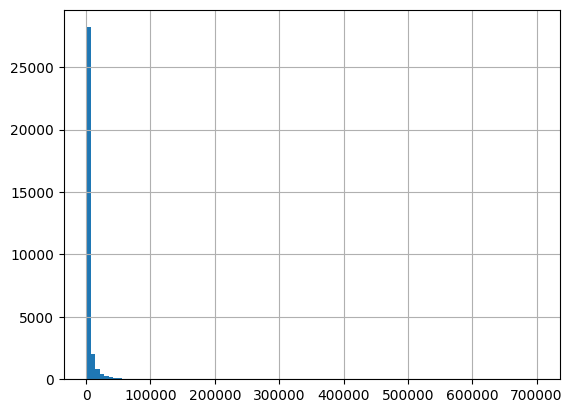

In [24]:
targets.hist(bins=100)

The distribution is heavily skewed, with a long and heavy tail consisting of high-cost individuals. This manifests itself in the mean being five times the median, the standard deviation being three times the mean, and the most costly individuals running into the hundreds of thousands of dollars.

## Task 3: Using SHAP
Please investigate the following cells' outputs to answer the following questions.

A. **[Team, TURN THIS IN]** Inspect the SHAP summary plot (AKA the "beeswarm plot"). Describe any interpretations you make from it, including clustering of feature values and impact on the output.

B. **[Each, TURN THIS IN]** Interact with the visualization in the last cell. Does it lead you to any insights? Why or why not? As you answer this question, be sure to use the drop-down menus to reorganize the data in various ways and also mouse over the visualization to see the results from the popups.

[SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

To get an overview of which features are most important for a model we can just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs), providing feature importance.

* Positive SHAP values indicate a feature pushing the model's output higher, while negative values pull it lower.
* The magnitude of a SHAP value signifies the strength of a feature's impact on a particular prediction.

In [25]:
# Train and evaluate GBRT
gbr = GradientBoostingRegressor(n_estimators=500, random_state=0)
gbr.fit(dfTrain, targetsTrain)
print('Training R^2:', r2_score(targetsTrain, gbr.predict(dfTrain)))
print('Test R^2:', r2_score(targetsTest, gbr.predict(dfTest)))

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
summary = shap.kmeans(dfTrain, 10)

Training R^2: 0.5291484898255039
Test R^2: -0.05427379471604876


To go deeper, we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

In [26]:
# obtain the explainer
explainer = shap.KernelExplainer(gbr.predict, summary)
shap_values = explainer.shap_values(dfTest)

  0%|          | 0/325 [00:00<?, ?it/s]

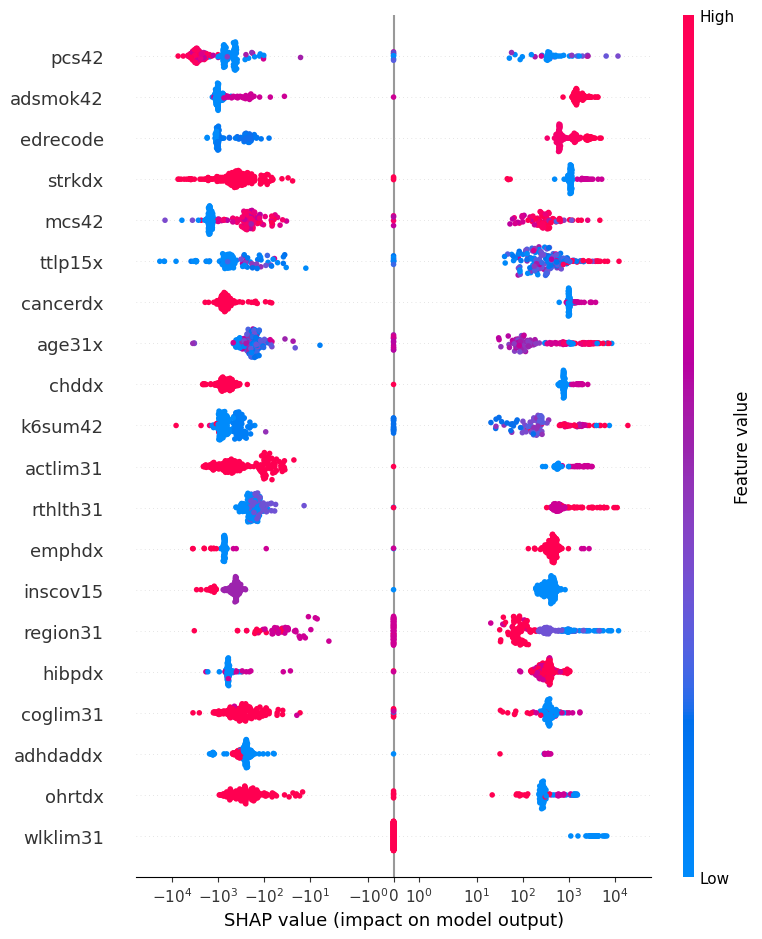

In [27]:
# explain all the predictions in the test set
shap.summary_plot(shap_values, dfTest,use_log_scale=True)

Another way to look at all the Shapley values is with this interactive "force plot"

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, dfTest)

## Task 4: Generate Different Charts

A. **[Team, TURN THIS IN]** Work together to generate a "dependence plot" (refer to the SHAP docs). Include a picture of your output in your submission. What do you see in it?

B. **[Team, TURN THIS IN]** Work together to generate a "force plot" explaining a single prediction (refer to the SHAP docs). Use that code to check out 3 the explanation for the inputs located in the dataset at indices 35, 273, and 300. Include a picture of your output in your submission. What do you see in these plots? How are they different or similar?


# Task 5: Big Picture

A. **[Each, TURN THIS IN]** Dig around in the links provided in the first cell and learn a bit about some of the other features SHAP offers. Describe a few that look interesting to you and why.

B. **[Each, TURN THIS IN]** To inform your final project, see if there are any other packages besides SHAP, LIME, and AIX360 that might offer useful tools for whatever project idea you might have in mind.

C. **[Each, TURN THIS IN]** Having finished this lab, re-read what you wrote for task A1. How has your position changed?

## 1. Task 1: Expectation before beginning
A. **[Each, TURN THIS IN]** Before beginning this assignment, briefly characterize in writing your expectation of what you will find to be predictive of an individual having high medical expenses. We learned about this in the last labs, but this one will use a different model and a different explainer. So how do you think this one might be different?

B. Run the following cells in Pre-task to set up packages and prepare the data

Note that the data retrieval and wrangling are the same as in the previous lab



### Predicting Medical Expenditures - Use Case Information

The Medical Expenditure Panel Survey (MEPS) is a set of large-scale surveys of families and individuals, their medical providers, and employers across the United States. MEPS is the most complete source of data on the cost and use of health care and health insurance coverage. For more information on MEPS, consult the following link (you may be particularly interested to search up column names in the codebook to understand their meaning and the values each can take):

https://meps.ahrq.gov/mepsweb/

We will work on the 2015 Full Year Consolidated Data file (HC-181), downloaded from:

https://www.nber.org/research/data/ahrq-medical-expenditure-panel-survey-data-meps

The contents of this notebook pull from the resources located here:

https://github.com/Trusted-AI/AIX360/blob/master/examples/tutorials/MEPS.ipynb

https://github.com/Trusted-AI/AIX360/blob/master/examples/tutorials/HELOC.ipynb

https://github.com/gianluigilopardo/HELOC-Credit-Approval

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html

### Set up Packages and Retrieve Data

In [ ]:
!pip install aix360==0.3.0 # apparently the base command is just getting 0.1.0 and not the most recent
!pip install shap

In [ ]:
# import things we will need later
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore') # send warnings to the dumpster (keeps output clean)

from aix360.datasets import MEPSDataset
from aix360.algorithms.rbm import FeatureBinarizer, LinearRuleRegression

import shap

In [ ]:
# grab from the internet the file: https://data.nber.org/meps/h181/h181.csv
# put it in the path: /usr/local/lib/python3.8/dist-packages/aix360/data/meps_data
# use "-nc" flag to prevent the download from clobbering a file we may already have downloaded
!wget -nc --directory-prefix=/content https://data.nber.org/meps/h181/h181.csv

File ‘/content/h181.csv’ already there; not retrieving.



### Wrangle Data

In [ ]:
# make a list of the Categorical features
categoricalFeaturesList =  ['region31', 'marry31x', 'edrecode', 'ftstu31x', 'actdty31', 'honrdc31',
                            'rthlth31', 'mnhlth31', 'hibpdx', 'chddx', 'angidx', 'midx', 'ohrtdx',
                            'strkdx', 'emphdx', 'chbron31', 'choldx', 'cancerdx', 'diabdx',
                            'jtpain31', 'arthdx', 'arthtype', 'asthdx', 'adhdaddx', 'pregnt31',
                            'wlklim31', 'actlim31', 'soclim31', 'coglim31', 'dfhear42', 'dfsee42',
                            'adsmok42', 'phq242', 'empst31', 'povcat15', 'inscov15']

allFeaturesList = ['region31', 'age31x', 'sex', 'racev2x', 'marry31x', 'edrecode', 'ftstu31x',
                   'actdty31', 'honrdc31', 'rthlth31', 'mnhlth31', 'hibpdx', 'chddx', 'angidx',
                   'midx', 'ohrtdx', 'strkdx', 'emphdx', 'chbron31', 'choldx', 'cancerdx', 'diabdx',
                   'jtpain31', 'arthdx', 'arthtype', 'asthdx', 'adhdaddx', 'pregnt31', 'wlklim31',
                   'actlim31', 'soclim31', 'coglim31', 'dfhear42', 'dfsee42', 'adsmok42', 'pcs42',
                   'mcs42', 'k6sum42', 'phq242', 'empst31', 'povcat15', 'inscov15', 'ttlp15x',
                   'totexp15', 'perwt15f']

# The processing function adjusts the dataframe that we get back
# it is a required argument because this library is rather badly written...
def processingFn(df):
  print("The initial dataset has " + str(df.shape[0])  + " instances and " + str(df.shape[1]-1) + " features.")
  rows = df.shape[0]
  df = df[(df[categoricalFeaturesList] >= -1).all(1)]  #for all categorical features, remove values < -1
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data in a variety of ways.")
  rows = df.shape[0]

  df = df[df['region31'] >= 0] # remove rows with census REGION value -1 (inapplicable)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data REGION.")
  rows = df.shape[0]
  df = df[df['age31x'] >= 0] # remove rows with AGE value -1 (inapplicable)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data AGE.")
  rows = df.shape[0]
  df = df[df['marry31x'] >= 0] # remove values -1, -7, -8, -9 (inapplicable, dont know, refused, or not ascertained)
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for incomplete data MARRIAGE status.")
  rows = df.shape[0]

  df = df[df['ttlp15x'] >= 0] # remove rows with negative personal income
  print("Shape ", df.shape[0], " removed ", rows - df.shape[0], " rows for negative personal income.") #FIXME do we need this
  rows = df.shape[0]

  df = df[allFeaturesList] # remove columns that we did not select
  print("Final Shape ", df.shape, " after dropping a ton of columns")

  # Reset index to consecutive integers
  df.reset_index(drop=True, inplace=True)

  return df

In [ ]:
data = MEPSDataset(custom_preprocessing=processingFn,dirpath="/content").data()

The initial dataset has 35427 instances and 1830 features.
Shape  33379  removed  2048  rows for incomplete data in a variety of ways.
Shape  32477  removed  902  rows for incomplete data REGION.
Shape  32477  removed  0  rows for incomplete data AGE.
Shape  32477  removed  0  rows for incomplete data MARRIAGE status.
Shape  32468  removed  9  rows for negative personal income.
Final Shape  (32468, 45)  after dropping a ton of columns


In [ ]:
data.columns

Index(['region31', 'age31x', 'sex', 'racev2x', 'marry31x', 'edrecode',
       'ftstu31x', 'actdty31', 'honrdc31', 'rthlth31', 'mnhlth31', 'hibpdx',
       'chddx', 'angidx', 'midx', 'ohrtdx', 'strkdx', 'emphdx', 'chbron31',
       'choldx', 'cancerdx', 'diabdx', 'jtpain31', 'arthdx', 'arthtype',
       'asthdx', 'adhdaddx', 'pregnt31', 'wlklim31', 'actlim31', 'soclim31',
       'coglim31', 'dfhear42', 'dfsee42', 'adsmok42', 'pcs42', 'mcs42',
       'k6sum42', 'phq242', 'empst31', 'povcat15', 'inscov15', 'ttlp15x',
       'totexp15', 'perwt15f'],
      dtype='object')

In [ ]:
# Separate target variables for regression
targets = data.pop('totexp15')


# Split data into training and test sets
dfTrain, dfTest, targetsTrain, targetsTest = train_test_split(data, targets, random_state=0, test_size=.01)

## Task 2: Investigate Data

A. Run the following cells to investigate the data

B. **[Team, TURN THIS IN]** Inspect the features, description of targets, and histogram of target values. The notebook asserts that this distribution is hard for regression to accurately model. Comment on why specifically you think this might be the case from a mechanistic perspective (i.e., if data instance A is predicted to have value X, but its real value is Y, then...)

In [ ]:
# This is what the features looks like
dfTrain.head()

,region31,age31x,sex,racev2x,marry31x,edrecode,ftstu31x,actdty31,honrdc31,rthlth31,...,adsmok42,pcs42,mcs42,k6sum42,phq242,empst31,povcat15,inscov15,ttlp15x,perwt15f
18505,2,23,2,1,5,13,3,2,2,1,...,2,33.06,59.87,0,0,1,4,2,21000,4074.623300
16981,1,22,1,12,5,14,1,2,2,3,...,1,50.01,45.27,3,1,4,1,2,6120,1484.980200
4288,4,80,2,5,1,16,-1,4,2,3,...,2,45.63,59.42,0,0,4,5,1,54124,2818.710998
1773,3,0,2,1,6,-1,-1,3,3,3,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,4112.433716
13224,3,15,2,1,6,2,-1,3,3,1,...,-1,-1.00,-1.00,-1,-1,-1,4,2,0,4973.630177


In [ ]:
targets.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     32468.000000
mean       4190.228933
std       14162.329524
min           0.000000
10%           0.000000
20%          40.000000
30%         177.000000
40%         359.000000
50%         649.000000
60%        1150.200000
70%        2095.000000
80%        4136.000000
90%        9768.000000
max      700771.000000
Name: totexp15, dtype: float64

<Axes: >

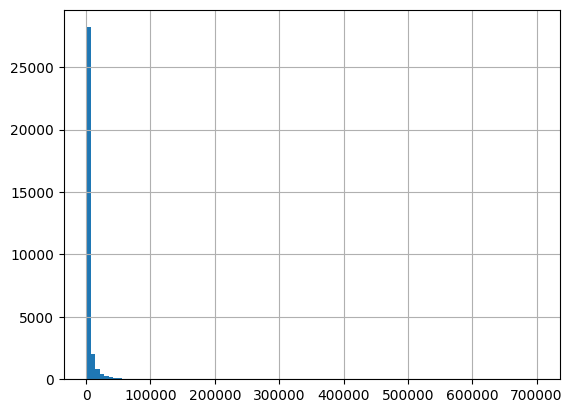

In [ ]:
targets.hist(bins=100)

The distribution is heavily skewed, with a long and heavy tail consisting of high-cost individuals. This manifests itself in the mean being five times the median, the standard deviation being three times the mean, and the most costly individuals running into the hundreds of thousands of dollars.

## Task 3: Using SHAP
Please investigate the following cells' outputs to answer the following questions.

A. **[Team, TURN THIS IN]** Inspect the SHAP summary plot (AKA the "beeswarm plot"). Describe any interpretations you make from it, including clustering of feature values and impact on the output.

B. **[Each, TURN THIS IN]** Interact with the visualization in the last cell. Does it lead you to any insights? Why or why not? As you answer this question, be sure to use the drop-down menus to reorganize the data in various ways and also mouse over the visualization to see the results from the popups.

[SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

To get an overview of which features are most important for a model we can just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs), providing feature importance.

* Positive SHAP values indicate a feature pushing the model's output higher, while negative values pull it lower.
* The magnitude of a SHAP value signifies the strength of a feature's impact on a particular prediction.

In [ ]:
# Train and evaluate GBRT
gbr = GradientBoostingRegressor(n_estimators=500, random_state=0)
gbr.fit(dfTrain, targetsTrain)
print('Training R^2:', r2_score(targetsTrain, gbr.predict(dfTrain)))
print('Test R^2:', r2_score(targetsTest, gbr.predict(dfTest)))

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
summary = shap.kmeans(dfTrain, 10)

Training R^2: 0.5291484898255039
Test R^2: -0.05427379471604876


To go deeper, we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

In [ ]:
# obtain the explainer
explainer = shap.KernelExplainer(gbr.predict, summary)
shap_values = explainer.shap_values(dfTest)

  0%|          | 0/325 [00:00<?, ?it/s]

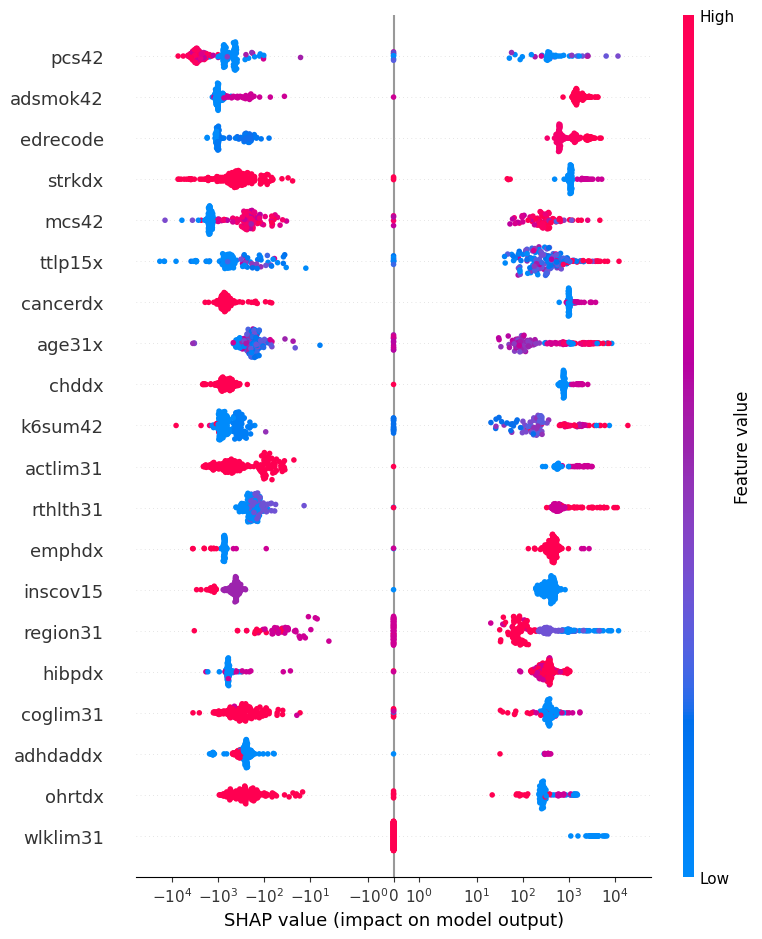

In [ ]:
# explain all the predictions in the test set
shap.summary_plot(shap_values, dfTest,use_log_scale=True)

Another way to look at all the Shapley values is with this interactive "force plot"

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, dfTest)

## Task 4: Generate Different Charts

A. **[Team, TURN THIS IN]** Work together to generate a "dependence plot" (refer to the SHAP docs). Include a picture of your output in your submission. What do you see in it?

B. **[Team, TURN THIS IN]** Work together to generate a "force plot" explaining a single prediction (refer to the SHAP docs). Use that code to check out 3 the explanation for the inputs located in the dataset at indices 35, 273, and 300. Include a picture of your output in your submission. What do you see in these plots? How are they different or similar?


# Task 5: Big Picture

A. **[Each, TURN THIS IN]** Dig around in the links provided in the first cell and learn a bit about some of the other features SHAP offers. Describe a few that look interesting to you and why.

B. **[Each, TURN THIS IN]** To inform your final project, see if there are any other packages besides SHAP, LIME, and AIX360 that might offer useful tools for whatever project idea you might have in mind.

C. **[Each, TURN THIS IN]** Having finished this lab, re-read what you wrote for task A1. How has your position changed?